In [1]:
import os
from argparse import Namespace
from collections import Counter
import json
import re
import string

import gensim
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
from torch.nn import init
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report
from sklearn.cluster import MiniBatchKMeans
from sklearn import preprocessing

%matplotlib inline

In [2]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None, mask_token="<MASK>", unk_token="<UNK>", num_token='<NUM>'):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            mask_token (str): the MASK token to add into the Vocabulary; indicates
                a position that will not be used in updating the model's parameters
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
            
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}

        self._unk_token = unk_token
        self._mask_token = mask_token
        self._num_token = num_token
        
        self.unk_index = self.add_token(unk_token) 
        self.num_index = self.add_token(num_token)
        self.mask_index = self.add_token(self._mask_token)
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token, 
                'mask_token': self._mask_token,
                'num_token': self._num_token,
               }

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.is_number(token):
            return self.num_index
            
        return self._token_to_idx.get(token, self.unk_index)
    
    def is_number(self, token):
        num_regex = re.compile('^[+-]?[0-9]+\.?[0-9]*$')

        return bool(num_regex.match(token))

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [3]:
class Vectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""    
    def __init__(self, cbow_vocab):
        """
        Args:
            cbow_vocab (Vocabulary): maps words to integers
        """
        self.cbow_vocab = cbow_vocab

    def vectorize(self, context, vector_length=-1):
        """
        Args:
            context (str): the string of words separated by a space
            vector_length (int): an argument for forcing the length of index vector
        """

        indices = [self.cbow_vocab.lookup_token(token) for token in context.split(' ')]
        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[-len(indices):] = indices
        out_vector[:-len(indices)] = self.cbow_vocab.mask_index

        return out_vector
    
    @classmethod
    def from_dataframe(cls, cbow_df):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            cbow_df (pandas.DataFrame): the target dataset
        Returns:
            an instance of the CBOWVectorizer
        """
        cbow_vocab = Vocabulary()
        for index, row in cbow_df.iterrows():
            for token in row.context.split(' '):
                cbow_vocab.add_token(token)
            cbow_vocab.add_token(row.target)
            
        return cls(cbow_vocab)

    @classmethod
    def from_serializable(cls, contents):
        cbow_vocab = \
            Vocabulary.from_serializable(contents['cbow_vocab'])
        return cls(cbow_vocab=cbow_vocab)

    def to_serializable(self):
        return {'cbow_vocab': self.cbow_vocab.to_serializable()}

In [4]:
class Dataset(Dataset):
    def __init__(self, train_df, test_df, vectorizer):
        """
        Args:
            cbow_df (pandas.DataFrame): the dataset
            vectorizer (CBOWVectorizer): vectorizer instatiated from dataset
        """
        self.train_df = train_df
        self.train_size = len(train_df)
        
        self.test_df = test_df
        self.test_size = len(test_df)
        
        self._vectorizer = vectorizer
        
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, train_df.sentence))
        
        self._lookup_dict = {
            'train': (self.train_df, self.train_size),
            'test': (self.test_df, self.test_size)
        }
        
        self.set_split('train')
        
    @property
    def mex_seq_length(self):
        return self._max_seq_length

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]
    
    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]
        target = 0.

        context_vector = self._vectorizer.vectorize(row.sentence, self._max_seq_length)

        return {
            'x_data': context_vector,
            'y_target': 0. if self._target_split == 'train' else row.label,
        }

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size
    

In [5]:
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device) \
            if isinstance(data_dict[name], torch.Tensor) else data_dict[name]
        yield out_data_dict

In [6]:
def preprocess_text(text):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

In [7]:
def get_centroids(w2v_model, aspects_count):
    """
        Clustering all word vectors with K-means and returning L2-normalizes
        cluster centroids; used for ABAE aspects matrix initialization
    """

    km = MiniBatchKMeans(n_clusters=aspects_count, verbose=0, n_init=100)
    m = []

    for k in w2v_model.wv.vocab:
        m.append(w2v_model.wv[k])

    m = np.matrix(m)

    km.fit(m)
    clusters = km.cluster_centers_

    # L2 normalization
    norm_aspect_matrix = clusters / np.linalg.norm(clusters, axis=-1, keepdims=True)

    return norm_aspect_matrix

In [8]:
class SelfAttention(torch.nn.Module):
    def __init__(self, wv_dim: int, maxlen: int):
        super(SelfAttention, self).__init__()
        self.wv_dim = wv_dim

        # max sentence length -- batch 2nd dim size
        self.maxlen = maxlen
        self.M = Parameter(torch.empty(size=(wv_dim, wv_dim)))
        init.kaiming_uniform_(self.M.data)

        self.tanh = nn.Tanh()
        self.attention_softmax = torch.nn.Softmax(dim=1)

    def forward(self, input_embeddings):
        # (b, wv, 1)
        mean_embedding = torch.mean(input_embeddings, (1,)).unsqueeze(2)

        # (wv, wv) x (b, wv, 1) -> (b, wv, 1)
        product_1 = torch.matmul(self.M, mean_embedding)

        # (b, maxlen, wv) x (b, wv, 1) -> (b, maxlen, 1)
        product_2 = torch.matmul(input_embeddings, product_1).squeeze(2)

        results = self.attention_softmax(self.tanh(product_2))

        return results

    def extra_repr(self):
        return 'wv_dim={}, maxlen={}'.format(self.wv_dim, self.maxlen)

In [9]:
class ABAE(torch.nn.Module):
    """
        The model described in the paper ``An Unsupervised Neural Attention Model for Aspect Extraction''
        by He, Ruidan and  Lee, Wee Sun  and  Ng, Hwee Tou  and  Dahlmeier, Daniel, ACL2017
        https://aclweb.org/anthology/papers/P/P17/P17-1036/
    """

    def __init__(
        self, 
        wv_dim, 
        asp_count,
        ortho_reg, 
        maxlen, 
        init_aspects_matrix,
        pretrained_embedding,
        padding_index,
        encoder_only=False,
    ):
        """Initializing the model
        
        :param wv_dim: word vector size
        :param asp_count: number of aspects
        :param ortho_reg: coefficient for tuning the ortho-regularizer's influence
        :param maxlen: sentence max length taken into account
        :param init_aspects_matrix: None or init. matrix for aspects
        """
        super(ABAE, self).__init__()
        self.wv_dim = wv_dim
        self.asp_count = asp_count
        self.ortho = ortho_reg
        self.maxlen = maxlen

        self.embedding = torch.nn.Embedding.from_pretrained(
            torch.FloatTensor(pretrained_embedding), 
            padding_idx=padding_index,
        )
        
        self.attention = SelfAttention(wv_dim, maxlen)
        self.linear_transform = torch.nn.Linear(self.wv_dim, self.asp_count)
        self.softmax_aspects = torch.nn.Softmax(dim=1)
        self.aspects_embeddings = Parameter(torch.empty(size=(wv_dim, asp_count)))

        if init_aspects_matrix is None:
            torch.nn.init.xavier_uniform(self.aspects_embeddings)
        else:
            self.aspects_embeddings.data = torch.from_numpy(init_aspects_matrix.T)
            
        self.encoder_only = encoder_only

    def get_aspects_importances(self, text_embeddings):
        """Takes embeddings of a sentence as input, returns attention weights

        """
        # compute attention scores, looking at text embeddings average
        attention_weights = self.attention(text_embeddings)

        # multiplying text embeddings by attention scores -- and summing
        # (matmul: we sum every word embedding's coordinate with attention weights)
        weighted_text_emb = torch.matmul(attention_weights.unsqueeze(1),  # (batch, 1, sentence)
                                         text_embeddings  # (batch, sentence, wv_dim)
                                         ).squeeze()

        # encoding with a simple feed-forward layer (wv_dim) -> (aspects_count)
        raw_importances = self.linear_transform(weighted_text_emb)

        # computing 'aspects distribution in a sentence'
        aspects_importances = self.softmax_aspects(raw_importances)

        return attention_weights, aspects_importances, weighted_text_emb

    def forward(self, text_embeddings, negative_samples_texts):
        
        text_embeddings = self.embedding(text_embeddings)

        # encoding: words embeddings -> sentence embedding, aspects importances
        _, aspects_importances, weighted_text_emb = self.get_aspects_importances(text_embeddings)
        
        if self.encoder_only:
            return aspects_importances
        else:
            negative_samples_texts = self.embedding(negative_samples_texts)
            
            # negative samples are averaged
            averaged_negative_samples = torch.mean(negative_samples_texts, dim=1)
            averaged_negative_samples = torch.mean(averaged_negative_samples, dim=1)
            
            # decoding: aspects embeddings matrix, aspects_importances -> recovered sentence embedding
            recovered_emb = torch.matmul(self.aspects_embeddings, aspects_importances.unsqueeze(2)).squeeze()
            
            return weighted_text_emb, recovered_emb, averaged_negative_samples

    def get_aspect_words(self, w2v_model, topn=10):
        words = []

        # getting aspects embeddings
        aspects = self.aspects_embeddings.cpu().detach().numpy()

        # getting scalar products of word embeddings and aspect embeddings;
        # to obtain the ``probabilities'', one should also apply softmax
        words_scores = w2v_model.wv.vectors.dot(aspects)

        for row in range(aspects.shape[1]):
            argmax_scalar_products = np.argsort(- words_scores[:, row])[:topn]
            words.append([w2v_model.wv.index2word[i] for i in argmax_scalar_products])

        return words

In [10]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

        
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'model_filename': args.model_state_file}


def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['train_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

In [11]:
args = Namespace(
    train_data='preprocessed_data/restaurant/train.txt',
    test_data='preprocessed_data/restaurant/test.txt',
    test_labels='preprocessed_data/restaurant/test_label.txt',
    emb_path='preprocessed_data/restaurant/w2v_embedding',
    emb_dim=200,
    batch_size=50,
    vocab_size=9000,
    aspect_size=14,
    
    epochs=15,
    neg_size=20,
    maxlen=-1,
    ortho_reg=0.1,
    
    cuda=True,
    reload_from_files=False,
    learning_rate=1e-4 * 5,
    early_stopping_criteria=5,  
    catch_keyboard_interrupt=True,
    seed=1234,
    
    save_dir="model_storage",
    model_state_file="model.pth",
)

args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))
set_seed_everywhere(args.seed, args.cuda)
handle_dirs(args.save_dir)

Using CUDA: True


In [12]:
sentences = []
with open('preprocessed_data/restaurant/train.txt') as fp:
    for line in tqdm(fp.readlines()):
        sentences.append(line)
        
cleaned_sentences = [preprocess_text(sentence) for sentence in sentences]

print (len(cleaned_sentences), "sentences")
print ("Sample:", cleaned_sentences[42])

train_df = pd.DataFrame(cleaned_sentences, columns=["sentence"])

train_df.head()


279885 sentences
Sample: place fancy wouldn go date 


,sentence
0,like jeollado like roll sometimes price variet...
1,like roll tiny order anyway often get order wr...
2,money dependable fun place get sushi bring fri...
3,place great deal price food give
4,crab roll made real crab imitation crab


In [13]:
sentences = []
labels = []

with open('preprocessed_data/restaurant/test.txt') as fp:
    for line in tqdm(fp.readlines()):
        sentences.append(line)
        
with open('preprocessed_data/restaurant/test_label.txt') as fp:
    for line in tqdm(fp.readlines()):
        labels.append(line)
        
cleaned_sentences = [preprocess_text(sentence) for sentence in sentences]
cleaned_labels = [preprocess_text(label.split()[0]) for label in labels]
        
test_df = pd.DataFrame({'sentence': cleaned_sentences, 'label': cleaned_labels})

test_df.head()

,sentence,label
0,staff friendliest competent stickler service e...,staff
1,great group great date great early brunch nigh...,ambience
2,like cafe noir dont get wrong jsut people work...,staff
3,service terrible wait everything ask several d...,staff
4,waitress seems concerned looking good actually...,staff


In [14]:
w2v = gensim.models.Word2Vec.load(args.emb_path)
token2index_lim = {token: index for index, token in enumerate(w2v.wv.index2word) if index < args.vocab_size}
token2index_all = {token: index for index, token in enumerate(w2v.wv.index2word)}
vocab = Vocabulary(token2index_lim)
vectorizer = Vectorizer(vocab)
dataset = Dataset(train_df, test_df , vectorizer)

model = ABAE(
    wv_dim=args.emb_dim,
    asp_count=args.aspect_size,
    ortho_reg=args.ortho_reg, 
    maxlen=dataset.mex_seq_length, 
    init_aspects_matrix=get_centroids(w2v, args.aspect_size),
    pretrained_embedding=w2v.wv.vectors,
    padding_index=vocab.mask_index,
)

In [15]:
model = model.to(args.device)
loss_func = nn.TripletMarginLoss(margin=1, swap=False, reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode='min', 
    factor=0.5,
    patience=1
)

train_state = make_train_state(args)

In [16]:
epoch_bar = tqdm(
    desc='training routine', 
    total=args.epochs,
    position=1,
)

dataset.set_split('train')
train_bar = tqdm(
    desc='train',
    total=dataset.get_num_batches(args.batch_size), 
    position=1, 
)

for epoch_index in range(args.epochs):
    
    train_state['epoch_index'] = epoch_index
    
    # Iterate over training dataset
    # setup: batch generator, set loss to 0, set train mode on

    running_loss = 0.0
    model.train()

    batch_generator = generate_batches(
        dataset, 
        batch_size=args.batch_size, 
        device=args.device
    )
    
    neg_batch_generator = generate_batches(
        dataset, 
        batch_size=args.batch_size, 
        shuffle=False,
        device=args.device,
    )

    for batch_index, batch_dict in enumerate(batch_generator):

        optimizer.zero_grad()
        
        x = batch_dict['x_data']
        y = batch_dict['y_target'].float()
        x_neg = next(neg_batch_generator)['x_data']

        negative_samples = torch.stack(
            tuple([x_neg[torch.randperm(x_neg.shape[0])[:args.neg_size]] 
                   for _ in range(args.batch_size)])
        ).to(args.device)

        anchor, positive, negative = model(x, negative_samples)
        loss = loss_func(anchor, positive, negative)
        loss_t = loss.item()

        # compute the running loss
        running_loss += (loss_t - running_loss) / (batch_index + 1)
        
        # use loss to produce gradients
        loss.backward()

        # use optimizer to take gradient step
        optimizer.step()
        
        # update bar
        train_bar.set_postfix(loss=running_loss, epoch=epoch_index)
        train_bar.update()

    train_state['train_loss'].append(running_loss)
    train_state = update_train_state(args=args, model=model, train_state=train_state)
    scheduler.step(train_state['train_loss'][-1])
    
    print(batch_index, "batches, and LR:", optimizer.param_groups[0]['lr'])
    for i, aspect in enumerate(model.get_aspect_words(w2v)):
        print(i, " ".join([a for a in aspect]))
    print("Loss:", loss.item())
    print()

    if train_state['stop_early']:
        break

    train_bar.n = 0

    epoch_bar.set_postfix(best_val=train_state['early_stopping_best_val'])
    epoch_bar.update()

5596 batches, and LR: 0.0005
0 chicken sauce tomato onion potato fried mushroom grilled beef salad
1 worst dry overpriced top average best buck mediocre cost dollar
2 pay money didn dont want leave unless wouldn anything doesn
3 u minute asked table manager min seated waiter bill told
4 wall room ceiling space window floor wood lit lighting booth
5 entree portion course dish fixe prix price appetizer bill menu
6 went birthday saturday night friday anniversary week weekend sunday celebrate
7 year review worst lived ve citysearch recently ever manager reviewer
8 service staff waitstaff server waitress waiter bartender hostess attentive attitude
9 time go eat get area year ve week month place
10 great excellent good nice perfect delicious amazing wonderful fantastic awesome
11 tender perfectly tomato gras wood flavor seasoned sauce presented ingredient
12 cream chocolate banana ice apple creme strawberry butter tart de
13 cuisine fare authentic american food indian mexican neighborhood ja

5596 batches, and LR: 0.0005
0 sauce chicken tomato onion potato mushroom fried grilled bean garlic
1 dry overpriced worst top filet buck dollar average mediocre price
2 pay dont didn money unless want wouldn doesn anything leave
3 u minute asked table waiter manager min glass waitress water
4 room wall space ceiling window lit floor lighting booth wood
5 entree course portion fixe prix menu dish wine price bill
6 went birthday saturday week night anniversary weekend friday month dined
7 review year citysearch worst reviewer manager recently ever lived ve
8 service staff waitstaff food attentive atmosphere rude hostess friendly prompt
9 go reservation eat area wait get time sit ve waiting
10 great excellent good amazing awesome delicious nice best perfect fantastic
11 staff knowledgeable wood waitstaff gras tender tomato flavor professional helpful
12 cream chocolate ice banana creme apple strawberry butter tea fruit
13 cuisine fare american neighborhood authentic food indian mexican b

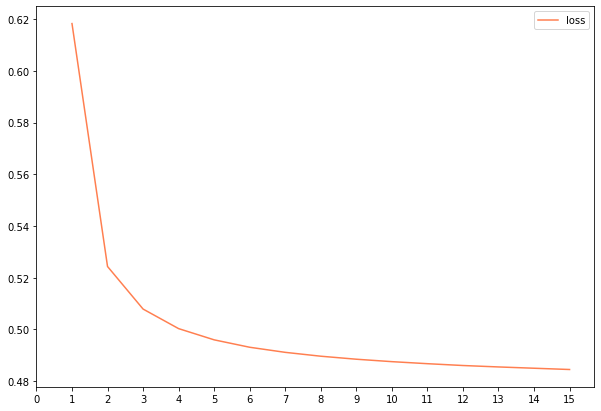

In [17]:
plt.figure(figsize=(10, 7))
sns.lineplot(
    x=[epoch + 1 for epoch in range(len(train_state['train_loss']))],
    y=train_state['train_loss'],
    color='coral', 
    label='loss',
)

plt.xticks([epoch for epoch in range(len(train_state['train_loss']) + 1)])
plt.show()

In [18]:
model.load_state_dict(torch.load(train_state['model_filename']))
model = model.to(args.device)
loss_func = torch.nn.MSELoss(reduction="sum")
dataset.set_split('test')

batch_generator = generate_batches(
    dataset, 
    batch_size=args.batch_size, 
    device=args.device,
    drop_last=False
)

model.eval()
model.encoder_only = True
predictions = []
targets = []

with torch.no_grad():
    for batch_index, batch_dict in enumerate(batch_generator):
        
        x = batch_dict['x_data']
        y_target = batch_dict['y_target']
        
        y_pred = model(x, None)
        for pred, target in zip(y_pred, y_target):
            predictions.append(pred.cpu().numpy().argmax())
            targets.append(target)

In [19]:
print(len(predictions))
print(len(targets))
print(Counter(predictions))
print(Counter(targets))

1490
1490
Counter({0: 704, 3: 270, 4: 209, 8: 103, 10: 61, 13: 38, 9: 28, 11: 18, 2: 17, 7: 15, 5: 15, 6: 12})
Counter({'food': 887, 'staff': 352, 'ambience': 251})


In [20]:
for i, aspect in enumerate(model.get_aspect_words(w2v)):
    print(i, " ".join([a for a in aspect]))

0 sauce tomato chicken onion potato mushroom fried bean grilled garlic
1 dry overpriced filet worst top buck dollar mediocre average price
2 pay dont didn money unless want wouldn doesn anything leave
3 u minute asked table waiter manager min waitress glass water
4 room wall space ceiling window lit floor lighting booth wood
5 entree course fixe portion prix menu dish wine bill price
6 went birthday saturday week night anniversary weekend friday month dined
7 review year citysearch reviewer manager worst recently owner ever chef
8 service staff waitstaff food attentive atmosphere rude friendly prompt hostess
9 reservation eat go area wait get time sit waiting ve
10 great excellent good amazing awesome delicious nice best perfect fantastic
11 wood staff knowledgeable waitstaff tender flavor tomato gras professional helpful
12 cream chocolate ice banana creme apple strawberry tea butter fruit
13 cuisine fare american neighborhood indian mexican authentic food bistro restaurant


In [40]:
cluster_map = {
    0: 'food', 
    1: 'miscellaneous', 
    2: 'staff', 
    3: 'staff',
    4: 'ambience', 
    5: 'food', 
    6: 'miscellaneous',  
    7: 'staff', 
    8: 'staff', 
    9: 'food', 
    10: 'food', 
    11: 'staff', 
    12: 'miscellaneous', 
    13: 'food'
}

labels = ['ambience', 'food', 'miscellaneous', 'price', 'staff']

y_pred = [cluster_map[pred] for pred in predictions]
y_true = targets

print(classification_report(y_true, y_pred))

               precision    recall  f1-score   support

     ambience       0.85      0.71      0.77       251
         food       0.90      0.86      0.88       887
miscellaneous       0.00      0.00      0.00         0
        staff       0.66      0.80      0.73       352

     accuracy                           0.82      1490
    macro avg       0.60      0.59      0.59      1490
 weighted avg       0.84      0.82      0.82      1490

